### 7. Experiment Data Augmentation

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import class_weight
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

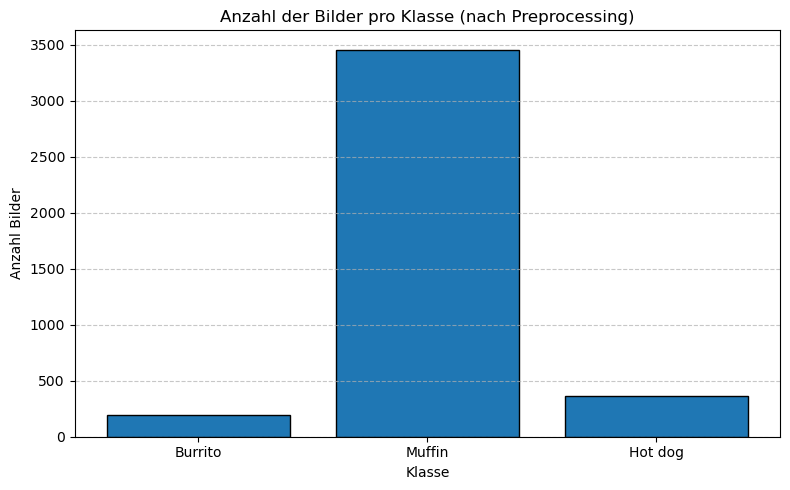

In [4]:
data_dir = "data_split/train"

# Bildanzahl pro Klasse
class_counts = {
    class_name: len([
        f for f in os.listdir(os.path.join(data_dir, class_name))
        if os.path.isfile(os.path.join(data_dir, class_name, f))
    ])
    for class_name in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, class_name))
}

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), edgecolor='black')
plt.title("Anzahl der Bilder pro Klasse (nach Preprocessing)")
plt.xlabel("Klasse")
plt.ylabel("Anzahl Bilder")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

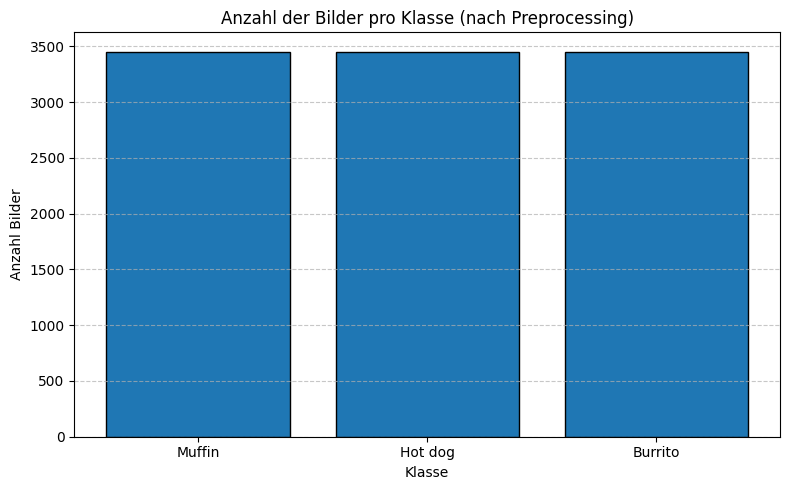

In [2]:
data_dir = "data_split/train_balanced"

# Bildanzahl pro Klasse
class_counts = {
    class_name: len([
        f for f in os.listdir(os.path.join(data_dir, class_name))
        if os.path.isfile(os.path.join(data_dir, class_name, f))
    ])
    for class_name in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, class_name))
}

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), edgecolor='black')
plt.title("Anzahl der Bilder pro Klasse (nach Preprocessing)")
plt.xlabel("Klasse")
plt.ylabel("Anzahl Bilder")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Klassenverteilung nach dem Preprocessing

Die Visualisierung zeigt, dass ein deutliches Ungleichgewicht zwischen den Klassen besteht:

- Muffin ist überrepräsentiert
- Hot dog und Burrito sind unterrepräsentiert

Dieses Ungleichgewicht kann das Training verzerren und sollte durch Data Augmentation berücksichtigt werden.

In [3]:
def plot_augmentation(aug_layer, img_path, title):
    img = Image.open(img_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_batch = tf.expand_dims(img_array, 0)

    augmented = aug_layer(img_batch)
    aug_img = tf.clip_by_value(augmented[0], 0.0, 1.0).numpy()

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(aug_img)
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [4]:
example_image=f"{data_dir}/Burrito/000003.jpg"

I0000 00:00:1745007143.200790  998569 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13397 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:3b:00.0, compute capability: 8.6


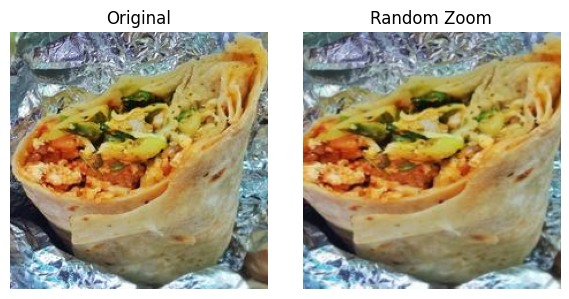

In [5]:
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.5, width_factor=0.2)
plot_augmentation(zoom_layer, example_image, "Random Zoom")

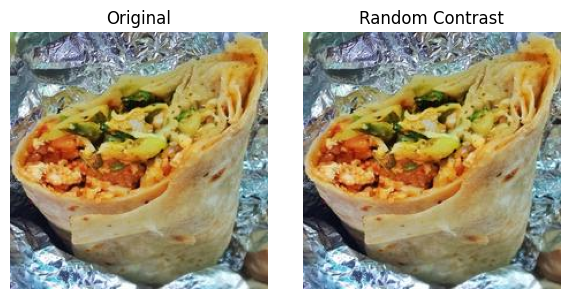

In [6]:
contrast_layer = tf.keras.layers.RandomContrast(factor=0.5)
plot_augmentation(contrast_layer, example_image, "Random Contrast")

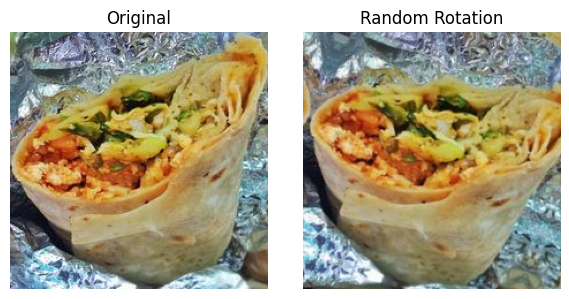

In [7]:
rotation_layer = tf.keras.layers.RandomRotation(factor=0.25)
plot_augmentation(rotation_layer, example_image, "Random Rotation")

### Load Training & Test Data

In [8]:
train_ds = image_dataset_from_directory(
    f"{data_dir}",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical",
    shuffle=True
)

val_ds = image_dataset_from_directory(
    f"data_split/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

Found 10362 files belonging to 3 classes.
Found 1861 files belonging to 3 classes.


In [9]:
# Extrahiere Labels aus dem train_ds
labels = []
for _, y in train_ds.unbatch():
    labels.append(np.argmax(y.numpy()))

# Berechne class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Konvertiere zu Dictionary (Keras erwartet das so)
class_weights = dict(enumerate(weights))

print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


2025-04-18 20:12:34.599760: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
def build_and_train_model(augmentation_layer, name, train_ds, val_ds):

    gpus = tf.config.list_physical_devices('GPU')
    gpu_status = "GPU available" if gpus else "GPU not available"
    print(f"Running on: {gpu_status}")
    
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        pooling="avg"
    )
    
    # #base_model.trainable = False
    
    # for layer in base_model.layers[:-30]:
    #    layer.trainable = False

    model = tf.keras.Sequential([
        augmentation_layer,
        base_model,
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        verbose=1,
        class_weight=class_weights
    )
    return history

def plot_histories(histories, save_path="training_results"):
    os.makedirs(save_path, exist_ok=True)  # Ordner erstellen, falls nicht vorhanden

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=f"{name} (val)")
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        plt.plot(history.history['val_loss'], label=f"{name} (val)")
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Speichern als PNG mit Timestamp im Namen
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"training_plot_{timestamp}.png"
    filepath = os.path.join(save_path, filename)
    plt.savefig(filepath, dpi=300)
    print(f"Plot gespeichert unter: {filepath}")

    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score
)
import os

def evaluate_and_plot_metrics(model, val_ds, class_names, name="model", save_dir="results/confusion_matrices"):
    # Vorhersagen
    y_pred = model.predict(val_ds)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Wahre Labels extrahieren
    y_true = []
    for _, labels in val_ds:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_true = np.array(y_true)

    # Metriken berechnen
    acc = accuracy_score(y_true, y_pred_classes)
    prec = precision_score(y_true, y_pred_classes, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred_classes, average="weighted")
    f1 = f1_score(y_true, y_pred_classes, average="weighted")

    print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    # Optional: detailed report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    # Confusion Matrix Plot
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.grid(False)

    # Save plot
    os.makedirs(save_dir, exist_ok=True)
    plot_path = os.path.join(save_dir, f"{name}_confusion_matrix.png")
    plt.savefig(plot_path, dpi=300)
    print(f"Confusion Matrix saved to: {plot_path}")
    plt.show()

### Define Pipelines

In [11]:
rescale = tf.keras.layers.Rescaling(1./255)

zoom_aug = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.3),
    rescale
])

contrast_aug = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.5),
    rescale
])

rotation_aug = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.25),
    rescale
])

In [12]:
histories = {}
histories["zoom"] = build_and_train_model(zoom_aug, "zoom", train_ds, val_ds)
histories["contrast"] = build_and_train_model(contrast_aug, "contrast", train_ds, val_ds)
histories["rotation"] = build_and_train_model(rotation_aug, "rotation", train_ds, val_ds)

Running on: GPU available
Epoch 1/10


I0000 00:00:1745007210.749927  998838 cuda_dnn.cc:529] Loaded cuDNN version 90300


324/324 ━━━━━━━━━━━━━━━━━━━━ 329s 840ms/step - accuracy: 0.6437 - loss: 0.9353 - val_accuracy: 0.0682 - val_loss: 12.7465
Epoch 2/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 258s 795ms/step - accuracy: 0.8216 - loss: 0.4954 - val_accuracy: 0.8135 - val_loss: 0.6191
Epoch 3/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 259s 798ms/step - accuracy: 0.9036 - loss: 0.2678 - val_accuracy: 0.9377 - val_loss: 0.1802
Epoch 4/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 258s 797ms/step - accuracy: 0.9418 - loss: 0.1770 - val_accuracy: 0.9103 - val_loss: 0.3686
Epoch 5/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 257s 795ms/step - accuracy: 0.9565 - loss: 0.1316 - val_accuracy: 0.8834 - val_loss: 0.3913
Epoch 6/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 258s 796ms/step - accuracy: 0.9597 - loss: 0.1230 - val_accuracy: 0.9522 - val_loss: 0.1455
Epoch 7/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 258s 796ms/step - accuracy: 0.9625 - loss: 0.1017 - val_accuracy: 0.9113 - val_loss: 1.3028
Epoch 8/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 258s 796ms/step - accuracy: 0.9689 - loss: 0.0

I0000 00:00:1745009857.990551  998836 service.cc:152] XLA service 0x53098eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745009857.990599  998836 service.cc:160]   StreamExecutor device (0): NVIDIA A2, Compute Capability 8.6
2025-04-18 20:57:40.021201: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-18 20:57:54.432550: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16719', 204 bytes spill stores, 204 bytes spill loads

2025-04-18 20:57:54.585423: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16719_0', 396 bytes spill stores, 2300 bytes spill loads

2025-04-18 20:57:55.376549: I external/local

323/324 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.6349 - loss: 0.9472

2025-04-18 21:00:55.793091: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16719', 4 bytes spill stores, 4 bytes spill loads

2025-04-18 21:00:56.094855: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16719', 8 bytes spill stores, 8 bytes spill loads

2025-04-18 21:00:56.969193: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16719', 220 bytes spill stores, 220 bytes spill loads

2025-04-18 21:00:57.209777: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21124', 24 bytes spill stores, 24 bytes spill loads

2025-04-18 21:00:57.251146: I external

324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.6350 - loss: 0.9466

2025-04-18 21:01:58.583981: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1770', 8 bytes spill stores, 8 bytes spill loads

2025-04-18 21:01:58.614082: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1770', 12 bytes spill stores, 12 bytes spill loads

2025-04-18 21:01:59.097930: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1770', 8 bytes spill stores, 8 bytes spill loads

2025-04-18 21:01:59.169961: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1770', 112 bytes spill stores, 112 bytes spill loads

2025-04-18 21:01:59.614299: I external/loc

324/324 ━━━━━━━━━━━━━━━━━━━━ 309s 624ms/step - accuracy: 0.6352 - loss: 0.9461 - val_accuracy: 0.8259 - val_loss: 0.8134
Epoch 2/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 126s 388ms/step - accuracy: 0.8728 - loss: 0.3625 - val_accuracy: 0.6013 - val_loss: 0.9147
Epoch 3/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 126s 388ms/step - accuracy: 0.9486 - loss: 0.1567 - val_accuracy: 0.8485 - val_loss: 0.5200
Epoch 4/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 126s 389ms/step - accuracy: 0.9741 - loss: 0.0758 - val_accuracy: 0.9683 - val_loss: 0.1549
Epoch 5/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 126s 388ms/step - accuracy: 0.9719 - loss: 0.0846 - val_accuracy: 0.9221 - val_loss: 0.2713
Epoch 6/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 126s 389ms/step - accuracy: 0.9552 - loss: 0.1510 - val_accuracy: 0.9382 - val_loss: 0.3170
Epoch 7/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 126s 388ms/step - accuracy: 0.9827 - loss: 0.0500 - val_accuracy: 0.9447 - val_loss: 0.2215
Epoch 8/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 126s 389ms/step - accuracy: 0.9879 - loss: 0.04

Plot gespeichert unter: training_results/training_plot_20250418_221742.png


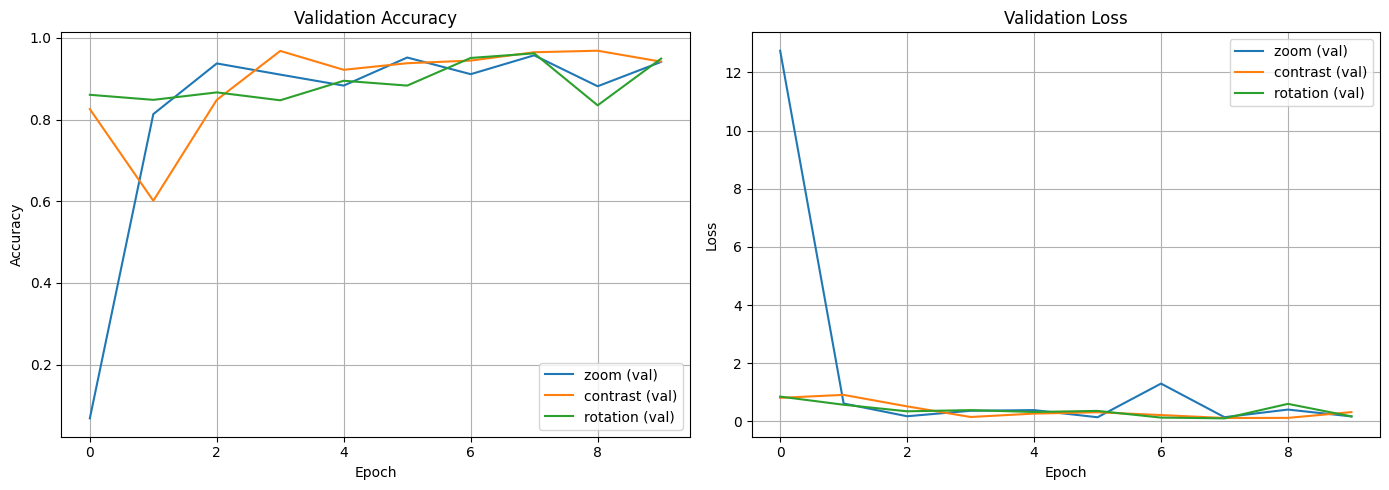

In [15]:
plot_histories(histories)

59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step
Zoom - Accuracy: 0.7609, Precision: 0.7459, Recall: 0.7609, F1: 0.7533

Classification Report:
              precision    recall  f1-score   support

     Burrito       0.03      0.02      0.02        92
     Hot dog       0.06      0.05      0.06       167
      Muffin       0.86      0.88      0.87      1602

    accuracy                           0.76      1861
   macro avg       0.32      0.32      0.32      1861
weighted avg       0.75      0.76      0.75      1861

Confusion Matrix saved to: results/confusion_matrices/Zoom_confusion_matrix.png


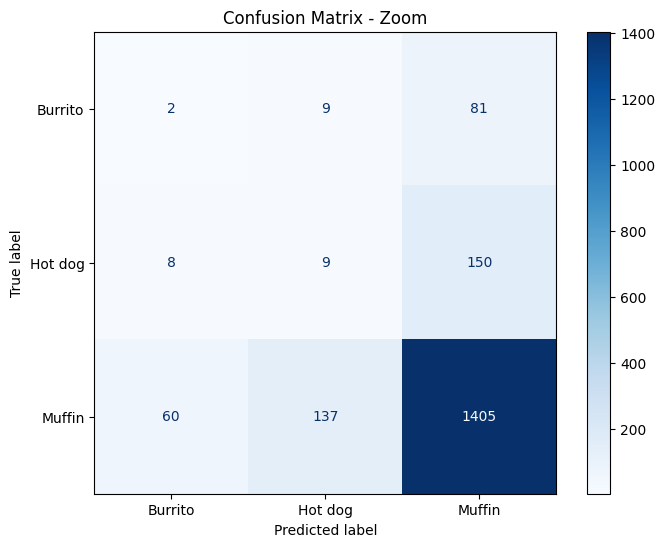

59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step
Contrast - Accuracy: 0.7958, Precision: 0.7567, Recall: 0.7958, F1: 0.7749

Classification Report:
              precision    recall  f1-score   support

     Burrito       0.06      0.05      0.06        92
     Hot dog       0.10      0.05      0.07       167
      Muffin       0.86      0.92      0.89      1602

    accuracy                           0.80      1861
   macro avg       0.34      0.34      0.34      1861
weighted avg       0.76      0.80      0.77      1861

Confusion Matrix saved to: results/confusion_matrices/Contrast_confusion_matrix.png


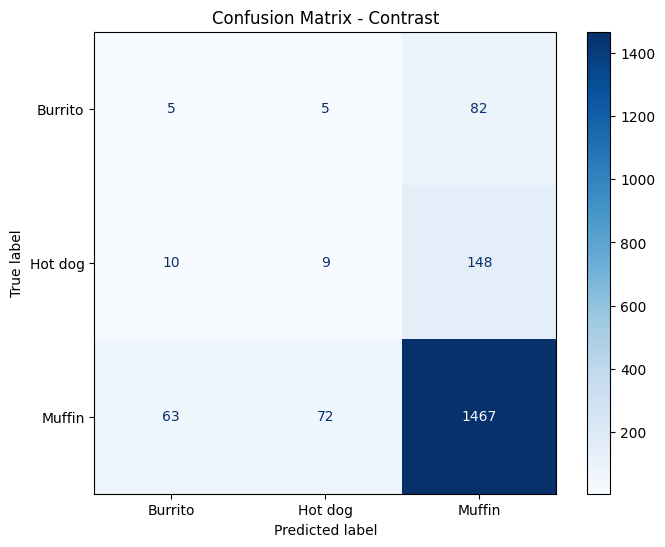

59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step
Rotation - Accuracy: 0.7851, Precision: 0.7502, Recall: 0.7851, F1: 0.7669

Classification Report:
              precision    recall  f1-score   support

     Burrito       0.03      0.02      0.03        92
     Hot dog       0.08      0.05      0.06       167
      Muffin       0.86      0.91      0.88      1602

    accuracy                           0.79      1861
   macro avg       0.32      0.33      0.32      1861
weighted avg       0.75      0.79      0.77      1861

Confusion Matrix saved to: results/confusion_matrices/Rotation_confusion_matrix.png


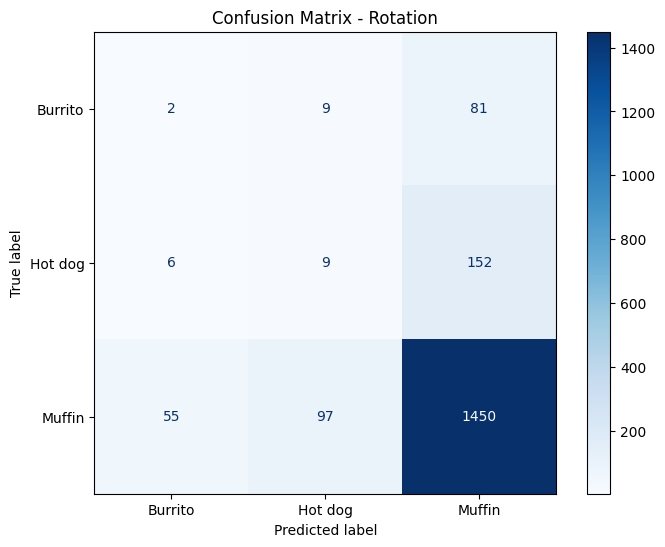

In [24]:
class_names = train_ds.class_names  # nur wenn train_ds aus image_dataset_from_directory kommt

evaluate_and_plot_metrics(model=histories["zoom"].model, val_ds=val_ds, class_names=class_names, name="Zoom")
evaluate_and_plot_metrics(model=histories["contrast"].model, val_ds=val_ds, class_names=class_names, name="Contrast")
evaluate_and_plot_metrics(model=histories["rotation"].model, val_ds=val_ds, class_names=class_names, name="Rotation")